*First compiled on May 5, 2017.*

# Clustering 3k PBMCs following a Seurat Tutorial

Scanpy allows to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) standard clustering tutorial as described on http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017). We gratefully acknowledge  the Seurat authors for publishing the tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [ ]:
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()
results_file = './write/pmbc3k.h5ad'

Running Scanpy 1.3.3 on 2019-01-04 12:23.
Dependencies: anndata==0.6.13 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
path = './data/filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).transpose()
adata.var_names = np.genfromtxt(path + 'genes.tsv', dtype=str)[:, 1]
adata.obs_names = np.genfromtxt(path + 'barcodes.tsv', dtype=str)

... reading from cache file ./cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var_names_make_unique()

In [4]:
sc.pl.highest_expr_genes(adata=adata, n_top=20)

## Preprocessing

Basic filtering.


In [5]:
sc.pp.filter_cells(adata, min_genes=200)


In [6]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells




Plot some information about mitochondrial genes, important for quality control

In [7]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1



A violin plot of the computed quality measures.

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)



Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [9]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

/home/kardel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/kardel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Actually do the filtering.

In [10]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]






Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the data stored in `adata_raw`.

In [11]:
adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw


Per-cell normalize the data matrix $\mathbf{X}$, identify highly-variable genes and compute logarithm.

In [12]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)



In [13]:

filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)


Actually do the filtering.

In [14]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [15]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [16]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


    finished (0:00:08.90)


In [17]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [18]:
adata.write(results_file)

## PCA

Compute PCA and make a scatter plot.

In [19]:
sc.tl.pca(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


In [20]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat R
sc.pl.pca_scatter(adata, color='CST3')


In [25]:
print(adata)
print(adata.raw.var_names)

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

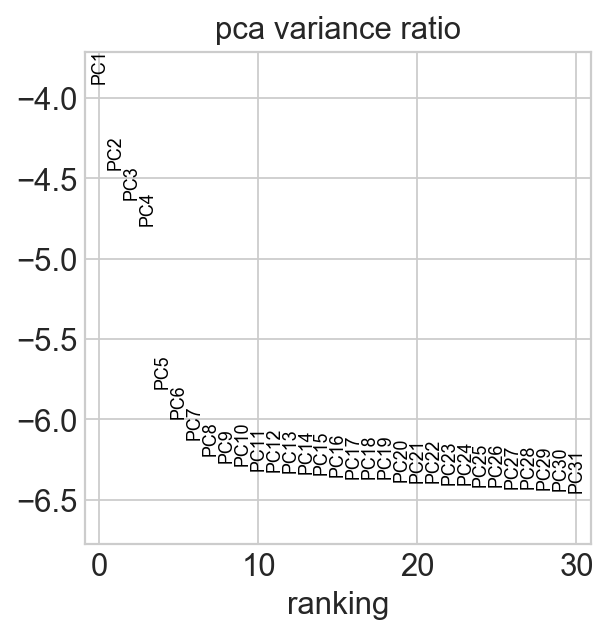

In [18]:
sc.pl.pca_variance_ratio(adata, log=True)

## tSNE

In [19]:
adata = sc.read(results_file)

In [20]:
sc.tl.tsne(adata, n_pcs=10, random_state=2)
adata.write(results_file)

computing tSNE
    computing 'X_pca' with n_pcs = 10
--> avoid this by setting n_pcs = 0
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:06.738) --> added
    'X_tsne', tSNE coordinates (adata.obs)


In [1]:
ax = sc.pl.tsne(adata, color=['CST3', 'NKG7'], color_map='RdBu_r')

NameError: name 'sc' is not defined

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression.

By setting `use_raw` to `False`, we can also plot the scaled and corrected expression.

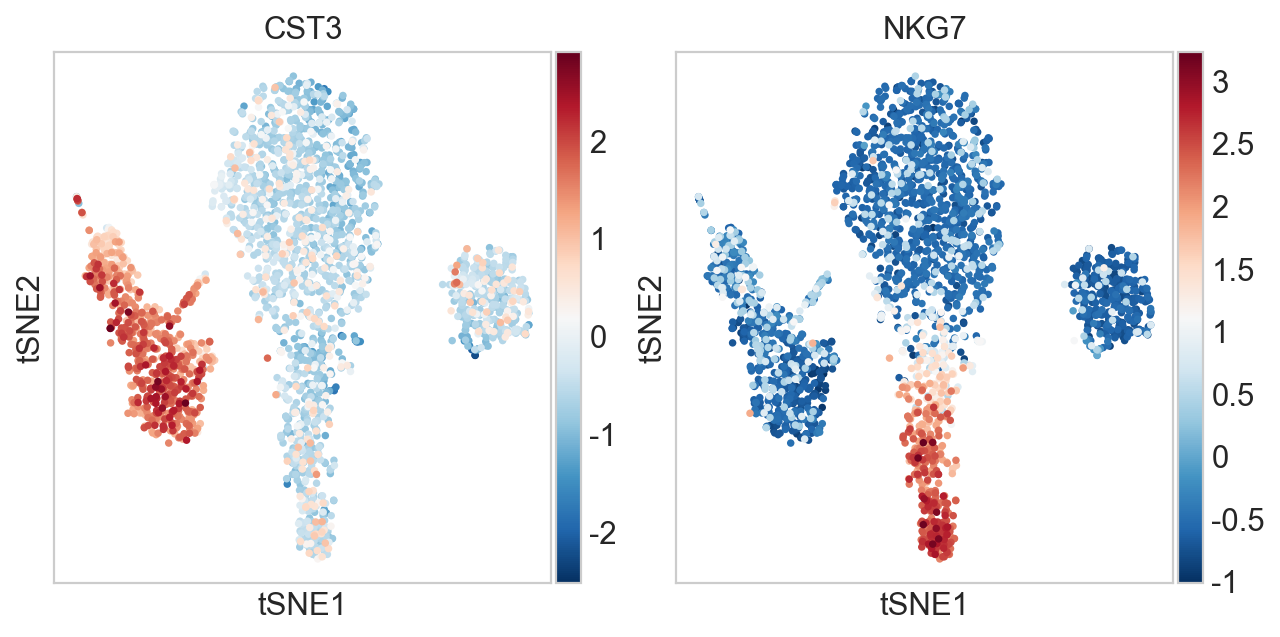

In [22]:
sc.pl.tsne(adata, color=['CST3', 'NKG7'], color_map='RdBu_r', use_raw=False)

## Clustering

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.04).

In [23]:
adata = sc.read(results_file)

In [24]:
sc.tl.louvain(adata, n_neighbors=10, resolution=1, recompute_graph=True)

running Louvain clustering
    compute 'X_pca' with n_pcs = 50 for building graph
    computing data graph with n_neighbors = 10 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [1.         0.9946003  0.9911751  0.9711884  0.96049607 0.9375494
     0.92748106 0.8487792  0.79404473 0.75507504 0.7454979  0.7444981
     0.7240369  0.71744734 0.698864  ]
    using the "louvain" package of Traag (2017)
    finished (0:00:00.998) --> found 8 clusters and added
    'louvain_groups', the cluster labels (adata.obs, dtype=category)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

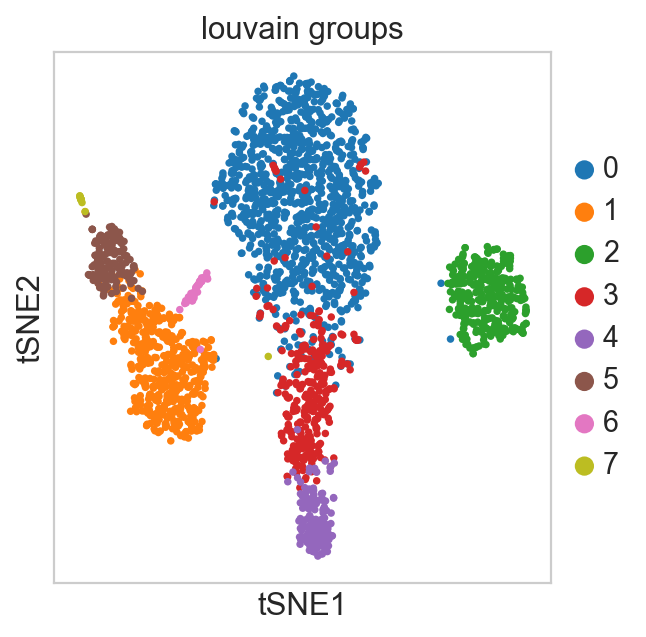

In [25]:
sc.pl.tsne(adata, color='louvain_groups')

Save this, in case we need it later.

In [26]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes by z-score, this agrees quite well with the more advanced tests of Seurat.

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.

rank differentially expressed genes
    consider 'louvain_groups': ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1144  480  342  316  154  150   37   15]
    finished (0:00:00.822) --> added
    'rank_genes_groups_gene_names', np.recarray to be indexed by group ids (adata.uns)
    'rank_genes_groups_gene_scores', np.recarray to be indexed by group ids (adata.uns)
saving figure to file ./figures/rank_genes_groups_louvain_groups.pdf


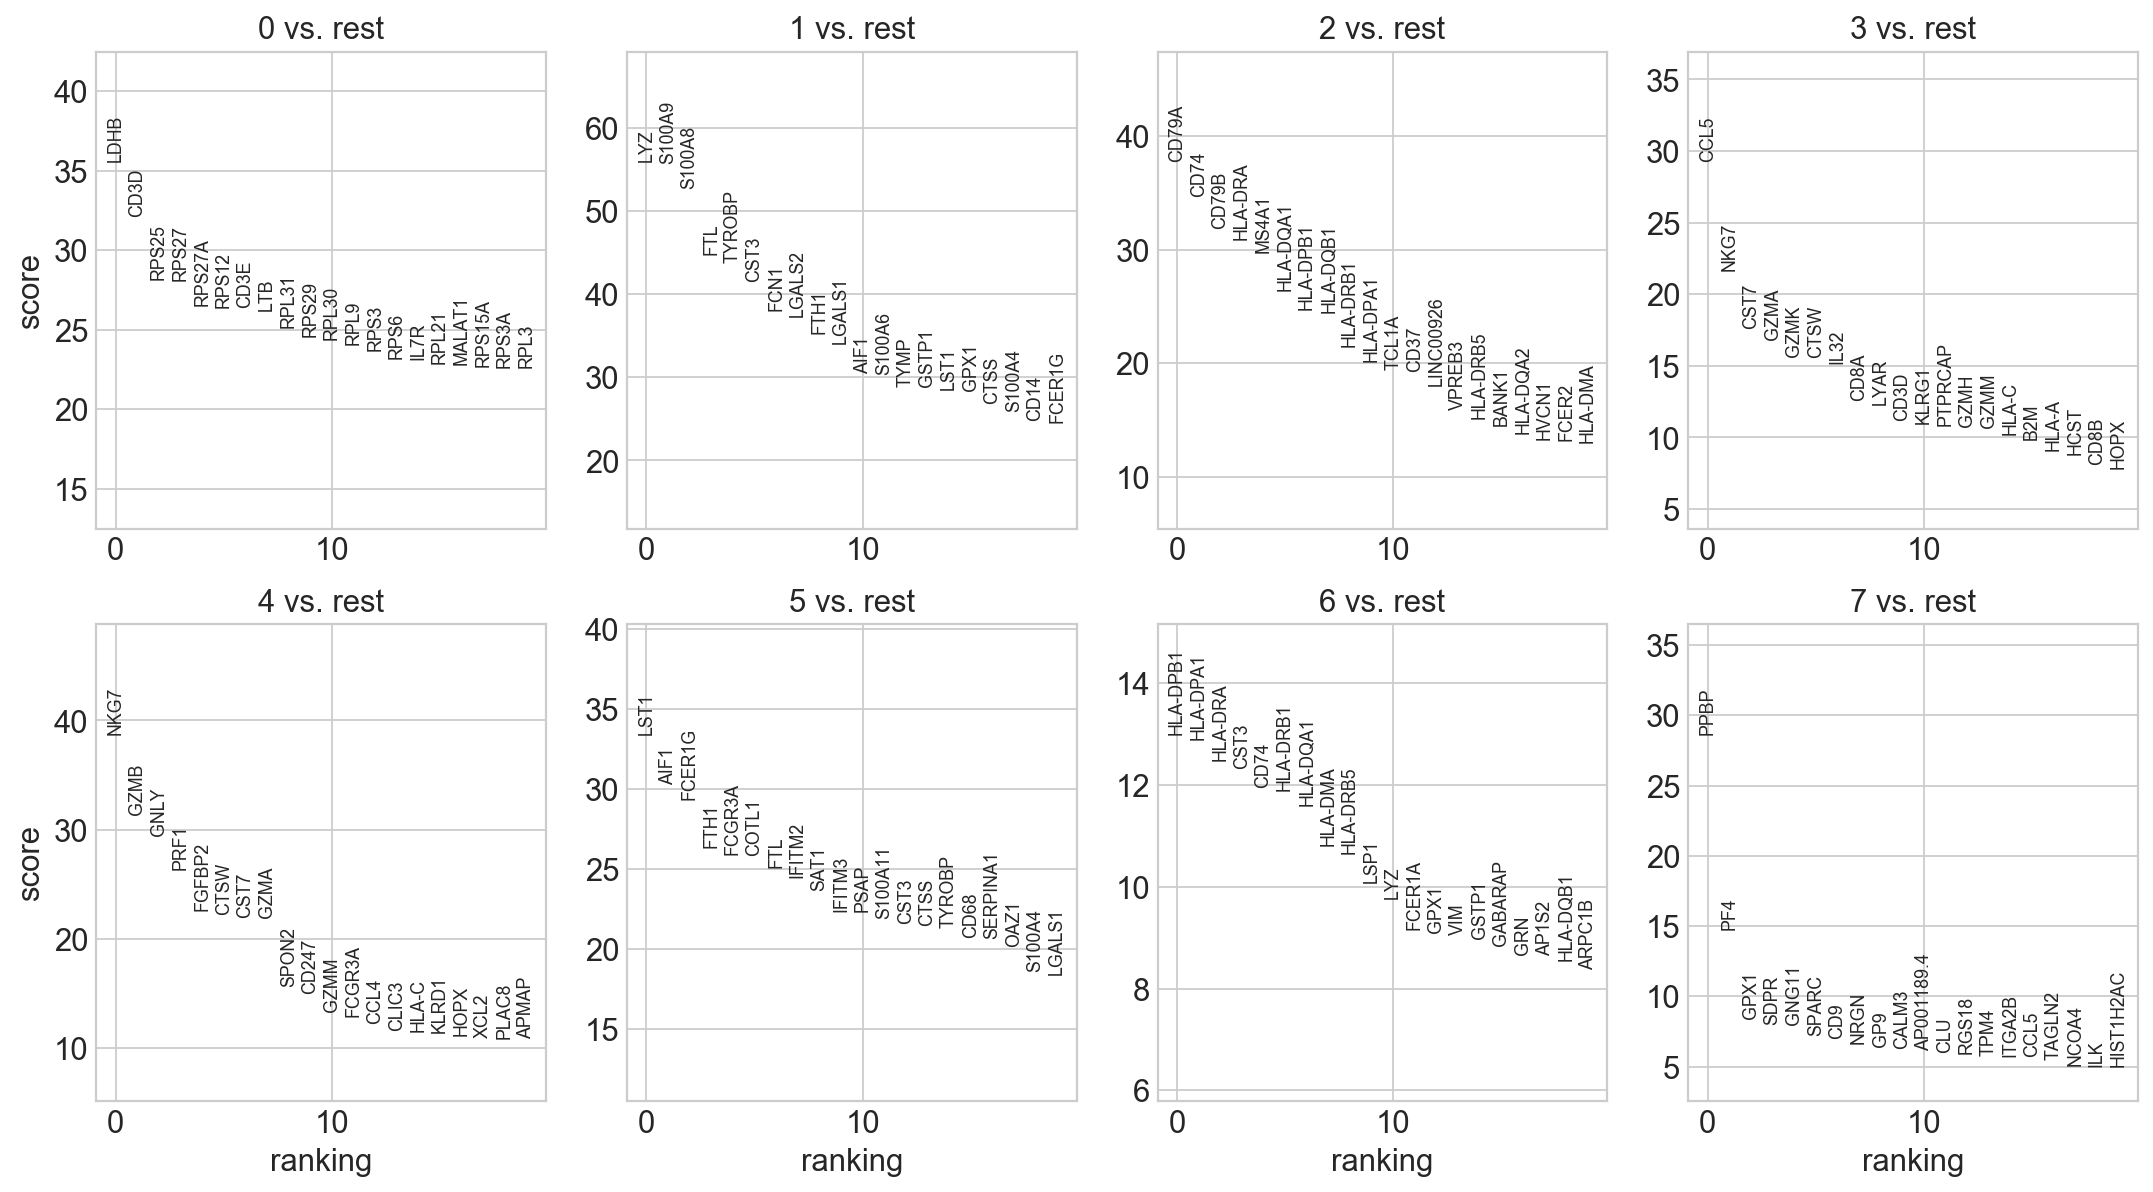

In [27]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain_groups')
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
adata.write(results_file)

Show the 20 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [28]:
import pandas as pd
pd.DataFrame(adata.uns['rank_genes_groups_gene_names']).loc[:20]

,0,1,2,3,4,5,6,7
0,LDHB,LYZ,CD79A,CCL5,NKG7,LST1,HLA-DPB1,PPBP
1,CD3D,S100A9,CD74,NKG7,GZMB,AIF1,HLA-DPA1,PF4
2,RPS25,S100A8,CD79B,CST7,GNLY,FCER1G,HLA-DRA,GPX1
3,RPS27,FTL,HLA-DRA,GZMA,PRF1,FTH1,CST3,SDPR
4,RPS27A,TYROBP,MS4A1,GZMK,FGFBP2,FCGR3A,CD74,GNG11
5,RPS12,CST3,HLA-DQA1,CTSW,CTSW,COTL1,HLA-DRB1,SPARC
6,CD3E,FCN1,HLA-DPB1,IL32,CST7,FTL,HLA-DQA1,CD9
7,LTB,LGALS2,HLA-DQB1,CD8A,GZMA,IFITM2,HLA-DMA,NRGN
8,RPL31,FTH1,HLA-DRB1,LYAR,SPON2,SAT1,HLA-DRB5,GP9
9,RPS29,LGALS1,HLA-DPA1,CD3D,CD247,IFITM3,LSP1,CALM3


Even though the ranking by z-scores is a very simple procedure, the resulting genes agree very well with the marker genes fround by Seurat. With the exception of the marker genes of group 4, all marker genes mentioned in the [Seurat Tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) can be found the rankings, and one can hence identify the cell types.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | 0
1 | CD14, LYZ | 1
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 |	GNLY, NKG7 | 	NK cells
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Compare to a single cluster. 

rank differentially expressed genes
    consider 'louvain_groups': ['0' '1'] with sample numbers [1144  480]
    finished (0:00:00.103) --> added
    'rank_genes_groups_gene_names', np.recarray to be indexed by group ids (adata.uns)
    'rank_genes_groups_gene_scores', np.recarray to be indexed by group ids (adata.uns)


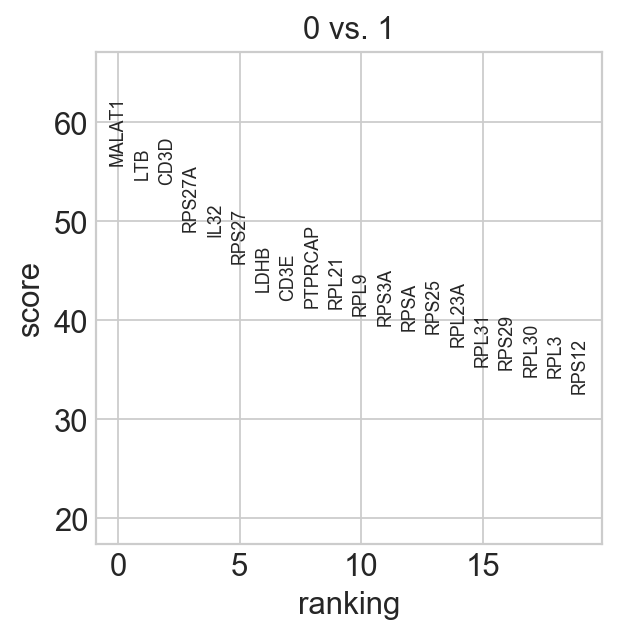

In [29]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain_groups', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

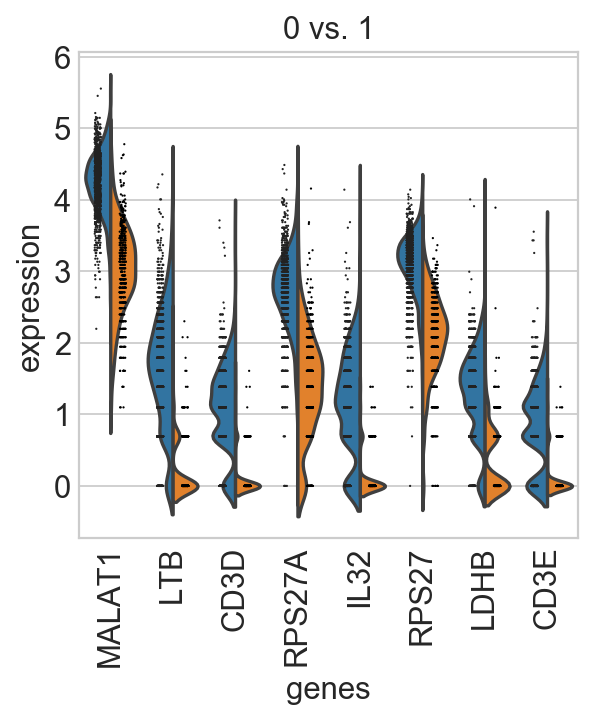

In [30]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

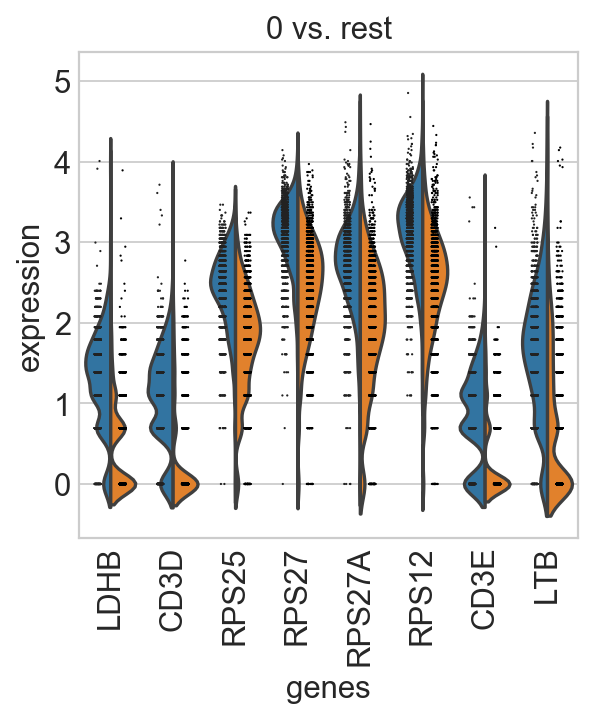

In [31]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

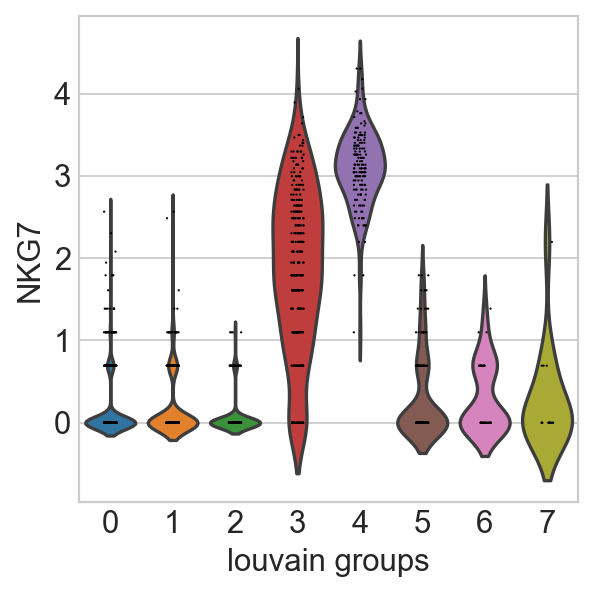

In [32]:
sc.pl.violin(adata, 'NKG7', group_by='louvain_groups')

Actually mark the cell types.

In [39]:
adata = sc.read(results_file)
adata.obs['louvain_groups'].cat.categories = [
    'CD4 T cells', 'CD14+ Monocytes',
    'B cells', 'CD8 T cells', 
    'NK cells', 'FCGR3A+ Monocytes',
    'Dendritic cells', 'Megakaryocytes']
adata.write(results_file)

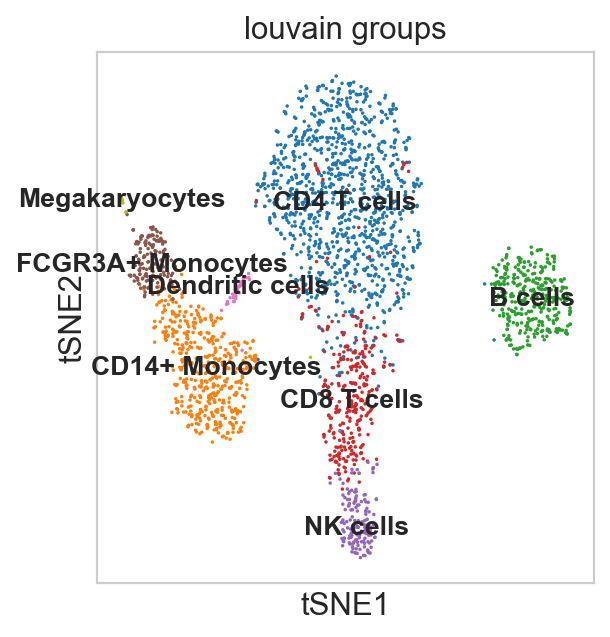

In [40]:
adata = sc.read(results_file)
sc.pl.tsne(adata, size=10,
           legend_fontsize=12, legend_fontweight='bold',
           color='louvain_groups',
           legend_loc='on data')

## Saving or exporting the results

Write the results using compression to save diskspace.

In [35]:
adata.write(results_file)

If you want to export to "csv", you will usually use pandas.

In [36]:
# Export single fields of the annotation of observations
adata.obs[['n_counts', 'louvain_groups']].to_csv(
    './write/pbmc3k_corrected_louvain_groups.csv')

In [37]:
# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/pbmc3k_corrected_X_pca.csv')

In [38]:
# Or export everything except the data using `.write_csvs`.
adata.write_csvs(results_file[:-5])